# Deep Recurrent Q Network

## Imports

In [1]:
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

from timeit import default_timer as timer
from datetime import timedelta
import math
import random

from utils.wrappers import *

from agents.DQN import Model as DQN_Agent

from networks.network_bodies import SimpleBody, AtariBody

from utils.ReplayMemory import ExperienceReplayMemory
from utils.hyperparameters import Config

## Hyperparameters

In [2]:
config = Config()

config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = config.device

#epsilon variables
config.epsilon_start = 1.0
config.epsilon_final = 0.01
config.epsilon_decay = 30000
config.epsilon_by_frame = lambda frame_idx: config.epsilon_final + (config.epsilon_start - config.epsilon_final) * math.exp(-1. * frame_idx / config.epsilon_decay)

#misc agent variables
config.GAMMA=0.99
config.LR=1e-4

#memory
config.TARGET_NET_UPDATE_FREQ = 1024
config.EXP_REPLAY_SIZE = 10000
config.BATCH_SIZE = 32

#Learning control variables
config.LEARN_START = 10000
config.MAX_FRAMES=1500000

#Nstep controls
config.N_STEPS=1

#DRQN Parameters
config.SEQUENCE_LENGTH=8

## Replay Buffer

In [3]:
class RecurrentExperienceReplayMemory:
    def __init__(self, capacity, sequence_length=10):
        self.capacity = capacity
        self.memory = []
        self.seq_length=sequence_length

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        finish = random.sample(range(0, len(self.memory)), batch_size)
        begin = [x-self.seq_length for x in finish]
        samp = []
        for start, end in zip(begin, finish):
            #correct for sampling near beginning
            final = self.memory[max(start+1,0):end+1]
            
            #correct for sampling across episodes
            for i in range(len(final)-2, -1, -1):
                if final[i][3] is None:
                    final = final[i+1:]
                    break
                    
            #pad beginning to account for corrections
            while(len(final)<self.seq_length):
                final = [(np.zeros_like(self.memory[0][0]), 0, 0, np.zeros_like(self.memory[0][3]))] + final
                            
            samp+=final

        #returns flattened version
        return samp, None, None

    def __len__(self):
        return len(self.memory)

## Network

In [4]:
class DRQN(nn.Module):
    def __init__(self, input_shape, num_actions, gru_size=512, bidirectional=False, body=AtariBody):
        super(DRQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.gru_size = gru_size
        self.bidirectional = bidirectional
        self.num_directions = 2 if self.bidirectional else 1

        self.body = body(input_shape, num_actions)
        self.gru = nn.GRU(self.body.feature_size(), self.gru_size, num_layers=1, batch_first=True, bidirectional=bidirectional)
        #self.fc1 = nn.Linear(self.body.feature_size(), self.gru_size)
        self.fc2 = nn.Linear(self.gru_size, self.num_actions)
        
    def forward(self, x, hx=None):
        batch_size = x.size(0)
        sequence_length = x.size(1)
        
        x = x.view((-1,)+self.input_shape)
        
        #format outp for batch first gru
        feats = self.body(x).view(batch_size, sequence_length, -1)
        hidden = self.init_hidden(batch_size) if hx is None else hx
        out, hidden = self.gru(feats, hidden)
        x = self.fc2(out)

        return x, hidden
        #return x

    def init_hidden(self, batch_size):
        return torch.zeros(1*self.num_directions, batch_size, self.gru_size, device=device, dtype=torch.float)
    
    def sample_noise(self):
        pass

## Agent

In [5]:
class Model(DQN_Agent):
    def __init__(self, static_policy=False, env=None, config=None):
        self.sequence_length=config.SEQUENCE_LENGTH

        super(Model, self).__init__(static_policy, env, config)

        self.reset_hx()
    
    def declare_networks(self):
        self.model = DRQN(self.num_feats, self.num_actions, body=AtariBody)
        self.target_model = DRQN(self.num_feats, self.num_actions, body=AtariBody)

    def declare_memory(self):
        self.memory = RecurrentExperienceReplayMemory(self.experience_replay_size, self.sequence_length)
        #self.memory = ExperienceReplayMemory(self.experience_replay_size)

    def prep_minibatch(self):
        transitions, indices, weights = self.memory.sample(self.batch_size)

        batch_state, batch_action, batch_reward, batch_next_state = zip(*transitions)

        shape = (self.batch_size,self.sequence_length)+self.num_feats

        batch_state = torch.tensor(batch_state, device=self.device, dtype=torch.float).view(shape)
        batch_action = torch.tensor(batch_action, device=self.device, dtype=torch.long).view(self.batch_size, self.sequence_length, -1)
        batch_reward = torch.tensor(batch_reward, device=self.device, dtype=torch.float).view(self.batch_size, self.sequence_length)
        #get set of next states for end of each sequence
        batch_next_state = tuple([batch_next_state[i] for i in range(len(batch_next_state)) if (i+1)%(self.sequence_length)==0])

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch_next_state)), device=self.device, dtype=torch.uint8)
        try: #sometimes all next states are false, especially with nstep returns
            non_final_next_states = torch.tensor([s for s in batch_next_state if s is not None], device=self.device, dtype=torch.float).unsqueeze(dim=1)
            non_final_next_states = torch.cat([batch_state[non_final_mask, 1:, :], non_final_next_states], dim=1)
            empty_next_state_values = False
        except:
            empty_next_state_values = True

        return batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values, indices, weights
    
    def compute_loss(self, batch_vars):
        batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values, indices, weights = batch_vars

        #estimate
        current_q_values, _ = self.model(batch_state)
        current_q_values = current_q_values.gather(2, batch_action).squeeze()
        
        #target
        with torch.no_grad():
            max_next_q_values = torch.zeros((self.batch_size, self.sequence_length), device=self.device, dtype=torch.float)
            if not empty_next_state_values:
                max_next, _ = self.target_model(non_final_next_states)
                max_next_q_values[non_final_mask] = max_next.max(dim=2)[0]
            expected_q_values = batch_reward + ((self.gamma**self.nsteps)*max_next_q_values)

        diff = (expected_q_values - current_q_values)
        loss = self.huber(diff)
        
        #mask first half of losses
        split = self.sequence_length // 2
        mask = torch.zeros(self.sequence_length, device=self.device, dtype=torch.float)
        mask[split:] = 1.0
        mask = mask.view(1, -1)
        loss *= mask
        
        loss = loss.mean()

        return loss

    def get_action(self, s, eps=0.1):
        with torch.no_grad():
            self.seq.pop(0)
            self.seq.append(s)
            if np.random.random() >= eps or self.static_policy or self.noisy:
                X = torch.tensor([self.seq], device=self.device, dtype=torch.float) 
                self.model.sample_noise()
                a, _ = self.model(X)
                a = a[:, -1, :] #select last element of seq
                a = a.max(1)[1]
                return a.item()
            else:
                return np.random.randint(0, self.num_actions)

    #def get_max_next_state_action(self, next_states, hx):
    #    max_next, _ = self.target_model(next_states, hx)
    #    return max_next.max(dim=1)[1].view(-1, 1)'''

    def reset_hx(self):
        #self.action_hx = self.model.init_hidden(1)
        self.seq = [np.zeros(self.num_feats) for j in range(self.sequence_length)]

## Plot Results

In [6]:
def plot(frame_idx, rewards, losses, sigma, elapsed_time):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s. time: %s' % (frame_idx, np.mean(rewards[-10:]), elapsed_time))
    plt.plot(rewards)
    if losses:
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
    if sigma:
        plt.subplot(133)
        plt.title('noisy param magnitude')
        plt.plot(sigma)
    plt.show()

## Training Loop

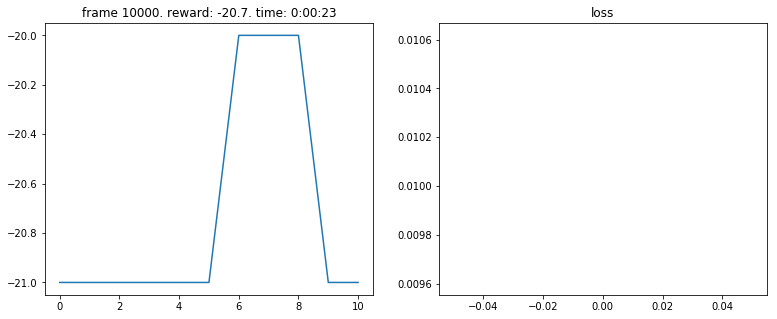

In [ ]:
start=timer()

env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env, frame_stack=False)
env    = wrap_pytorch(env)
model = Model(env=env, config=config)

episode_reward = 0

observation = env.reset()
for frame_idx in range(1, config.MAX_FRAMES + 1):
    epsilon = config.epsilon_by_frame(frame_idx)
    
    action = model.get_action(observation, epsilon)
    prev_observation=observation
    observation, reward, done, _ = env.step(action)
    observation = None if done else observation

    model.update(prev_observation, action, reward, observation, frame_idx)
    episode_reward += reward

    if done:
        model.finish_nstep()
        model.reset_hx()
        observation = env.reset()
        model.save_reward(episode_reward)
        episode_reward = 0
        
        if np.mean(model.rewards[-10:]) > 19:
            plot(frame_idx, model.rewards, model.losses, model.sigma_parameter_mag, timedelta(seconds=int(timer()-start)))
            break

    if frame_idx % 10000 == 0:
        plot(frame_idx, model.rewards, model.losses, model.sigma_parameter_mag, timedelta(seconds=int(timer()-start)))

model.save_w()
env.close()